In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import utils
import os

C:\Users\msubr\Anaconda3\envs\bert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("../data/UCF-crime-frames-descriptions-partitions.csv")

In [3]:
train = data.loc[data["partition"] == "train"]
val = data.loc[data["partition"] == "validation"]

In [4]:
X = np.load("../data/train.npy")
X = np.concatenate([X,np.load("../data/train_qformer.npy")], axis=1)
V = np.load("../data/val.npy")
V = np.concatenate([V,np.load("../data/val_qformer.npy")], axis=1)
X = torch.tensor(X, dtype=torch.float32)
V = torch.tensor(V, dtype=torch.float32)
y = list(train["class"])
y = np.array([utils.labels[lbl] for lbl in y])
y = torch.tensor(y, dtype=torch.float32)
y_val = list(val["class"])
y_val = np.array([utils.labels[lbl] for lbl in y_val])
y_val = torch.tensor(y_val, dtype=torch.float32)

In [5]:
labels_counts = torch.tensor([(y==i).sum() for i in range(len(utils.labels))])
weights = 1 - labels_counts / len(X)   

In [25]:
model = nn.Sequential(
    nn.Linear(2176, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Sequential(
  (0): Linear(in_features=2176, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=256, out_features=10, bias=True)
)

In [27]:
weights = weights.to(device)
loss_fn = nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [28]:
n_epochs = 30
batch_size = 64
for epoch in range(n_epochs):
    acc = 0
    perm = torch.randperm(len(X))
    for i in range(0, len(X), batch_size):
        Xbatch = X[perm[i:i+batch_size]]
        Xbatch = Xbatch.to(device)
        y_pred = model(Xbatch)
        ybatch = y[perm[i:i+batch_size]]
        ybatch = ybatch.type(torch.LongTensor)
        ybatch = ybatch.to(device)
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc += utils.get_acc(y_pred, ybatch, return_sum=True)
    val_pred = utils.evaluate(V, model, device, batch_size)
        
    print(f'Finished epoch {epoch}, latest loss {loss}, acc {acc/len(X)} val_acc {utils.get_acc(val_pred, y_val)}')

Finished epoch 0, latest loss 1.1606963872909546, acc 0.6666237115859985 val_acc 0.6366787552833557
Finished epoch 1, latest loss 0.8855680823326111, acc 0.7213984131813049 val_acc 0.6497672200202942
Finished epoch 2, latest loss 0.7025231719017029, acc 0.7546176314353943 val_acc 0.6576306223869324
Finished epoch 3, latest loss 0.7287799119949341, acc 0.7773974537849426 val_acc 0.6609932780265808
Finished epoch 4, latest loss 0.7414406538009644, acc 0.7954166531562805 val_acc 0.6573719382286072
Finished epoch 5, latest loss 0.604332685470581, acc 0.8072415590286255 val_acc 0.6572167873382568
Finished epoch 6, latest loss 0.4068881571292877, acc 0.8188489675521851 val_acc 0.6680806875228882
Finished epoch 7, latest loss 0.5977624654769897, acc 0.8256877064704895 val_acc 0.6566994190216064
Finished epoch 8, latest loss 0.6963638663291931, acc 0.8333320021629333 val_acc 0.6587170362472534
Finished epoch 9, latest loss 0.4222523272037506, acc 0.8421201109886169 val_acc 0.6621314287185669
F

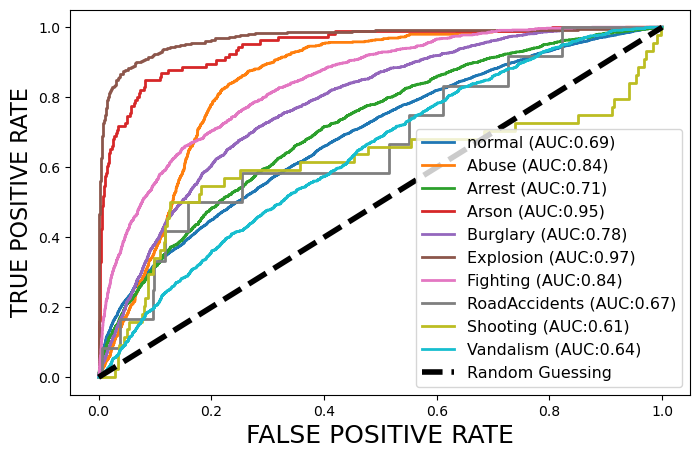

ROC AUC score: 0.7697711403392183


In [29]:
print('ROC AUC score:', utils.multiclass_roc_auc_score(y_val , val_pred, average = "macro"))

In [30]:
utils.get_acc_per_lbl(val_pred, y_val)
print("Acc:", utils.get_acc(val_pred, y_val))

0, presc 0.72, recall 0.88, f1 0.79	 total 12895 Normal
1, presc 0.26, recall 0.18, f1 0.21	 total 646 Abuse
2, presc 0.46, recall 0.07, f1 0.13	 total 1321 Arrest
3, presc 0.16, recall 0.58, f1 0.25	 total 106 Arson
4, presc 0.16, recall 0.12, f1 0.14	 total 1767 Burglary
5, presc 0.76, recall 0.38, f1 0.51	 total 388 Explosion
6, presc 0.48, recall 0.11, f1 0.18	 total 1132 Fighting
7, presc 0.00, recall 0.00, f1 nan	 total 12 RoadAccidents
8, presc 0.00, recall 0.02, f1 0.01	 total 44 Shooting
9, presc 0.29, recall 0.10, f1 0.15	 total 1019 Vandalism
Acc: tensor(0.6305)


In [31]:
torch.save(model.state_dict(), "models/model_image_all_features.pt")